In [0]:
import numpy as np

In [0]:
def read_file(path):
    with open(path) as f:
        file = f.readlines()
    return file

In [0]:
train_unp = read_file('/content/qa1_single-supporting-fact_train.txt')
test_unp  = read_file('/content/qa1_single-supporting-fact_test.txt')

In [4]:
len(train_unp)

3000

In [5]:
train_unp[0:10]

['1 Mary moved to the bathroom.\n',
 '2 John went to the hallway.\n',
 '3 Where is Mary? \tbathroom\t1\n',
 '4 Daniel went back to the hallway.\n',
 '5 Sandra moved to the garden.\n',
 '6 Where is Daniel? \thallway\t4\n',
 '7 John moved to the office.\n',
 '8 Sandra journeyed to the bathroom.\n',
 '9 Where is Daniel? \thallway\t4\n',
 '10 Mary moved to the hallway.\n']

In [0]:
import re
def pre_process(data):
    
    ret = []
    l1 = []
    que = []
    
    for i in range (len(data)):
        if (i+1)%3 != 0:
            for word in data[i].split():
                if re.match(r'\d',word) == None:
#                 if word not in '0123456789':
                    if word[-1] in '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~':
                        l1.append(word[0:-1])
                        l1.append(word[-1])
                    else:
                        l1.append(word)
        else:
            temp = data[i].split('\t')
            ans = temp[1]
            for word in temp[0].split():
                if re.match(r'\d',word) == None:
#                 if word not in '0123456789':
                    if word[-1] in '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~':
                        que.append(word[0:-1])
                        que.append(word[-1])
                    else:
                        que.append(word)

            tup = (l1,que,ans)
            ret.append(tup)
            l1 = []
            que = []
            
    return ret

In [0]:
train = pre_process(train_unp)
test = pre_process(test_unp)

In [8]:
train[0:2]

[(['Mary',
   'moved',
   'to',
   'the',
   'bathroom',
   '.',
   'John',
   'went',
   'to',
   'the',
   'hallway',
   '.'],
  ['Where', 'is', 'Mary', '?'],
  'bathroom'),
 (['Daniel',
   'went',
   'back',
   'to',
   'the',
   'hallway',
   '.',
   'Sandra',
   'moved',
   'to',
   'the',
   'garden',
   '.'],
  ['Where', 'is', 'Daniel', '?'],
  'hallway')]

In [0]:
all_data = train + test

In [0]:
vocab = set()
for story, query, ans in all_data:
    
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(query))
    if ans not in vocab:
        vocab.add(ans)

In [11]:
len(vocab)

21

In [12]:
vocab

{'.',
 '?',
 'Daniel',
 'John',
 'Mary',
 'Sandra',
 'Where',
 'back',
 'bathroom',
 'bedroom',
 'garden',
 'hallway',
 'is',
 'journeyed',
 'kitchen',
 'moved',
 'office',
 'the',
 'to',
 'travelled',
 'went'}

In [13]:
vocab_len = len(vocab) + 1
max_story_len =max([len(data[0]) for data in all_data])
max_story_len

14

In [14]:
max_question_len = max([len(data[1]) for data in all_data])
max_question_len

4

In [15]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [0]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [17]:
tokenizer.word_index

{'.': 5,
 '?': 19,
 'back': 7,
 'bathroom': 4,
 'bedroom': 11,
 'daniel': 8,
 'garden': 9,
 'hallway': 6,
 'is': 2,
 'john': 10,
 'journeyed': 21,
 'kitchen': 18,
 'mary': 15,
 'moved': 1,
 'office': 14,
 'sandra': 17,
 'the': 12,
 'to': 16,
 'travelled': 13,
 'went': 20,
 'where': 3}

In [18]:
tokenizer.texts_to_sequences(train[0][0])

[[15], [1], [16], [12], [4], [5], [10], [20], [16], [12], [6], [5]]

In [0]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):
    '''
    INPUT: 
    
    data: consisting of Stories,Queries,and Answers
    word_index: word index dictionary from tokenizer
    max_story_len: the length of the longest story (used for pad_sequences function)
    max_question_len: length of the longest question (used for pad_sequences function)


    OUTPUT:
    
    Vectorizes the stories,questions, and answers into padded sequences. We first loop for every story, query , and
    answer in the data. Then we convert the raw words to an word index value. Then we append each set to their appropriate
    output list. Then once we have converted the words to numbers, we pad the sequences so they are all of equal length.
    
    Returns this in the form of a tuple (X,Xq,Y) (padded based on max lengths)
    '''
    
    
    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []
    
    
    for story, query, answer in data:
        
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]
        
        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        y = np.zeros(len(word_index) + 1)
        
        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        #
        y[word_index[answer]] = 1
        
        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.
        
    # RETURN TUPLE FOR UNPACKING
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [0]:
story_train, queries_train, answers_train = vectorize_stories(train)
story_test, queries_test, answers_test = vectorize_stories(test)

In [0]:
from keras.models import Sequential, Model
from keras.layers import LSTM,Dense,Embedding,Input,Permute,Activation,Dropout
from keras.layers import add,dot,concatenate

In [0]:
input_seq = Input((max_story_len,))
question = Input((max_question_len,))

In [23]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim = vocab_len,output_dim=64))
input_encoder_m.add(Dropout(rate = 0.7))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim = vocab_len,output_dim=max_question_len))
input_encoder_c.add(Dropout(rate = 0.5))

In [0]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim = vocab_len,output_dim=64, input_length=max_question_len))
question_encoder.add(Dropout(rate = 0.5))

In [0]:
input_encoded_m = input_encoder_m(input_seq)
input_encoded_c = input_encoder_c(input_seq)
question_encoded = question_encoder(question)

In [0]:
match = dot([input_encoded_m,question_encoded],axes=(2,2))
match = Activation('softmax')(match)

In [0]:
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)

In [29]:
answer = concatenate([response, question_encoded])

answer

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 4, 78) dtype=float32>

In [0]:
answer = LSTM(32)(answer)

In [0]:
answer = Dropout(rate = 0.5)(answer)
answer = Dense(vocab_len)(answer)

In [0]:
answer = Activation('softmax')(answer)

model = Model([input_seq, question],answer)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 14)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             1408        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 4, 64)        1408        input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

In [34]:
history = model.fit([story_train, queries_train], answers_train,batch_size=32,
                    epochs=500,validation_data=([story_test, queries_test], 
                                                answers_test))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1000 samples, validate on 1000 samples
Epoch 1/500
1000/1000 [==============================] - 2s 2ms/step - loss: 2.7507 - acc: 0.1540 - val_loss: 2.2199 - val_acc: 0.1540
Epoch 2/500
1000/1000 [==============================] - 1s 675us/step - loss: 2.1611 - acc: 0.1560 - val_loss: 1.9150 - val_acc: 0.1540
Epoch 3/500
1000/1000 [==============================] - 1s 681us/step - loss: 2.0210 - acc: 0.1770 - val_loss: 1.8499 - val_acc: 0.1540
Epoch 4/500
1000/1000 [==============================] - 1s 677us/step - loss: 1.9629 - acc: 0.1820 - val_loss: 1.8400 - val_acc: 0.1570
Epoch 5/500
1000/1000 [==============================] - 1s 653us/step - loss: 1.9383 - acc: 0.1610 - val_loss: 1.8290 - val_acc: 0.1570
Epoch 6/500
1000/1000 [==============================] - 1s 671us/step - loss: 1.9192 - acc: 0.1600 - val_loss: 1.8165 - val_acc: 0.1890
Epoch 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


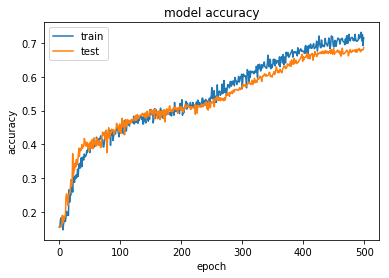

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()